In [73]:
import os
import spacy
import gensim
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [74]:
n = 70 # Choose a number for a song to inspect.

In [75]:
def getlistOfTexts(rootdir):
    # input: directory with (subdirectory with) TXT-files to be handled
	# output: list of files lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

liedjeslist = getlistOfTexts('../../data/liedjes')

In [76]:
print(liedjeslist[n])

../../data/liedjes/amsterdam1857-1-feestboekje1859/amsterdam1857-1-feestboekje1859-03.txt


In [77]:
def texts2list(listOfTexts):
	# input: list of files lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfTexts:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

liedjes = texts2list(liedjeslist)

In [78]:
print(liedjes[n])

Lof der drukkunst

Komt, allen in deez vriendenrij,
Zingt met verruimden zin,
Den lof der eedle Drukkerij,
Der Wereld-Koningin,
Zij is ’t, die slavenketens breekt,
Als door één bliksemschicht,
De dwing’landij ter nedersteekt,
En ’t gansch heelal verlicht.

De vrijheid, zoo in Kerk als Staat,
Dankt men aan haar bestaan;
Zij wijst hem, die als werkman gaat,
Zijn heil’ge regten aan;
Zij roept hem toe, met luider stem:
„Gevoel uw waarde als mensch,
„Zijt vrij, ontdaan van elken klem!’
Zie, dat ’s juist onze wensch.

Doch, bij die vrijheid wenschte ook ik
Het doel, zoo heerlijk schoon,
Der prijsvraag van Van Nifterick :
Te werken voor meer loon.
Komt, zweren wij dan allen hier,
Op de ingeslagen baan,
Vereenigd onder één banier,
Met ijver voort te gaan.



In [79]:
def lemmatize(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):   
    # input: list of texts
    # input: allowed_postags is list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized texts. Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch
    nlp.Defaults.stop_words |= {"deez", "zoo"} # optionally: add stopwords to processor

    result = []                                                         
    for text in texts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                        new_text.append(token.lemma_) # get the word in the lemma and add it to the list of words

        final = " ".join(new_text) # transform list of words into a string concatenating all listitems
        result.append(final) # add string to the list of lemmatized texts

    return result

lemmatized_liedjes = lemmatize(liedjes)


In [80]:

print(lemmatized_liedjes[n])

lof drukkunst komen vriendenrij verruimen zin eedl drukkerij slavenketen breken bliksemschicht dwingen landij nedersteekt gansch heelal verlichten vrijheid staat danken bestaan wijzen werkman gaan heil regten roepen luid stem gevoel waarde mensch ontdoen elk klem zien wensch vrijheid wenschen doel heerlijk schoon werken loon komen zweren inslaan baan banier ijver gaan


In [81]:
def preprocess(texts):
    # input: list of lemmatized texts
    # output: list of lists of preprocessed words, bigrams or trigrams. Preprocessing by gensim.

    # what kind of preprocessing does gensim do?
    result = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        result.append(new)

    # find bigrams and trigrams. Don't understand yet how precisely ... 
    bigram_phrases  = gensim.models.Phrases(result, min_count=5, threshold=100)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[result], threshold=100)
    bigram  = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)
    bigrams  = [bigram[doc] for doc in result]
    trigrams = [trigram[bigram[doc]] for doc in result]

    return trigrams

preprocessed_liedjes = preprocess(lemmatized_liedjes)

In [82]:

print(preprocessed_liedjes[n])

['lof', 'drukkunst', 'komen', 'vriendenrij', 'verruimen', 'zin', 'eedl', 'drukkerij', 'slavenketen', 'breken', 'bliksemschicht', 'dwingen', 'landij', 'nedersteekt', 'gansch', 'heelal', 'verlichten', 'vrijheid', 'staat', 'danken', 'bestaan', 'wijzen', 'werkman', 'gaan', 'heil', 'regten', 'roepen', 'luid', 'stem', 'gevoel', 'waarde', 'mensch', 'ontdoen', 'elk', 'klem', 'zien', 'wensch', 'vrijheid', 'wenschen', 'doel', 'heerlijk', 'schoon', 'werken', 'loon', 'komen', 'zweren', 'inslaan', 'baan', 'banier', 'ijver', 'gaan']


In [83]:
# create gensim Dictionary-thing for input in gensim-code: list of unique words in alphabetical order
# (similar to 'vocabulary' in the VSM script)
liedjes_gensimDict = gensim.corpora.Dictionary(preprocessed_liedjes) 
liedjes_gensimDict.filter_extremes(no_below = 5, no_above = 0.5, keep_n = 100000) 

In [84]:
# create 'bag-of-words'
# A bag of words is a list of 2-tuples (term_id, frequency), where term_id is id for a term in the liedjes_gensimDict.
liedjes_bow = []
for text in preprocessed_liedjes:
    new = liedjes_gensimDict.doc2bow(text)
    liedjes_bow.append(new)

In [85]:
print(liedjes_bow[n])

[(27, 1), (37, 1), (53, 1), (58, 1), (72, 1), (75, 1), (76, 1), (86, 1), (112, 1), (118, 2), (125, 1), (129, 2), (159, 1), (189, 1), (193, 1), (243, 1), (264, 1), (281, 1), (282, 1), (286, 1), (317, 1), (342, 1), (352, 1), (397, 1), (432, 1), (465, 1), (526, 1), (539, 1), (541, 1), (545, 1), (546, 1), (591, 1), (633, 1), (639, 1), (640, 1)]


In [86]:
# train model !!
lda_model = gensim.models.ldamodel.LdaModel(
    corpus  = liedjes_bow,         # corpus met documenten gerepresenteerd als bag-of-words
    id2word = liedjes_gensimDict,  # dictionary: lijst met identificatie nummers van alle woorden
    num_topics = 10,               # het aantal topics dat het algoritme zal identificeren 
    random_state = 0,              # seed voor het later kunnen reproduceren van de resultaten
    update_every = 0,              # 0 voor batch learning, > 1 voor online learning
    iterations = 100,              # aantal herhalingen
    chunksize = len(liedjes_bow),  # aantal gebruikte documenten per training 
    passes = 100,                  # aantal herhalingen gedurende een training 
    alpha = "auto",                # LDA hyperparameter, zie haalbaarheidsstudie
    eta = "symmetric")             # LDA hyperparameter, zie haalbaarheidsstudie

In [87]:
topicList = lda_model.print_topics()

In [88]:
for topic in topicList:
    print(topic)

(0, '0.030*"zingen" + 0.026*"eer" + 0.021*"feest" + 0.020*"drukkunst" + 0.019*"leven" + 0.019*"koster" + 0.015*"lied" + 0.015*"man" + 0.015*"drinken" + 0.013*"klinken"')
(1, '0.043*"kunst" + 0.023*"licht" + 0.022*"roem" + 0.018*"eer" + 0.015*"vinden" + 0.014*"drukkunst" + 0.014*"naam" + 0.012*"haarlems" + 0.011*"vinding" + 0.011*"grond"')
(2, '0.035*"feest" + 0.022*"jaar" + 0.018*"geest" + 0.016*"vreugde" + 0.016*"leven" + 0.015*"laten" + 0.014*"zingen" + 0.014*"vrolijk" + 0.014*"vieren" + 0.012*"hart"')
(3, '0.059*"gaan" + 0.024*"broeder" + 0.022*"staan" + 0.017*"dag" + 0.017*"goed" + 0.015*"weer" + 0.013*"vreugd" + 0.013*"zien" + 0.012*"groeten" + 0.012*"voorwaarts"')
(4, '0.029*"drinken" + 0.027*"feest" + 0.025*"glas" + 0.023*"vreugd" + 0.023*"laten" + 0.022*"zingen" + 0.022*"vrouw" + 0.020*"wijn" + 0.016*"vriendschap" + 0.016*"broeder"')
(5, '0.051*"hoezee" + 0.015*"hoeze" + 0.014*"lied" + 0.014*"geest" + 0.013*"blijde" + 0.013*"feest" + 0.013*"naam" + 0.013*"zien" + 0.013*"lof" + 

In [89]:
# get list of all topic-distributions per liedje
# a topic distribution is a list topics of a liedje. Every topic is a 2-tuples (topic_id, probability).
liedjes_topics_dist = lda_model.get_document_topics(liedjes_bow)

In [90]:
print(liedjes_topics_dist[n])

[(9, 0.9908793)]


In [91]:
#visualisatie met pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, liedjes_bow, liedjes_gensimDict)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.191176  0.102954       1        1  20.634844
2     -0.012906 -0.048551       2        1  16.402048
4      0.040117 -0.167614       3        1  11.721662
3      0.167197  0.085214       4        1   9.072243
0     -0.046896 -0.090074       5        1   8.288559
5     -0.034861 -0.019431       6        1   8.140026
6      0.039645 -0.056483       7        1   7.859419
8     -0.098599  0.055025       8        1   7.571976
7      0.168075  0.093357       9        1   6.699276
9     -0.030596  0.045604      10        1   3.609946, topic_info=        Term        Freq       Total Category  logprob  loglift
390   hoezee   67.000000   67.000000  Default  30.0000  30.0000
129     gaan  159.000000  159.000000  Default  29.0000  29.0000
136    kunst  197.000000  197.000000  Default  28.0000  28.0000
68     feest  212.000000  212.000000  Default  27.0000  27.0000
212  drinken   96.000000   96.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
200    waard    4.011701   46.886095  Topic10  -4.9609   0.8630
138     lied    4.884936  112.000552  Topic10  -4.7640   0.1891
75      heil    4.202013   81.028867  Topic10  -4.9146   0.3622
129     gaan    4.251561  159.730054  Topic10  -4.9029  -0.3047
122  broeder    3.740265  157.017250  Topic10  -5.0310  -0.4157

[627 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
190       1  0.633028      aard
190       2  0.090433      aard
190       4  0.022608      aard
190       5  0.067824      aard
190       7  0.045216      aard
...     ...       ...       ...
396       2  0.093194  zwichten
588       3  0.783794     zwier
588       8  0.130632     zwier
224       2  0.651897   zwieren
224       7  0.260759   zwieren

[1780 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 4, 1, 6, 7, 9, 8, 10])

In [92]:
coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=preprocessed_liedjes, dictionary=liedjes_gensimDict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.3017175459086819


In [103]:
# give all documents of specific topic
topic = 8
for n in range(len(liedjeslist)):
    if liedjes_topics_dist[n][0][0] == topic:
        print(liedjeslist[n])

../../data/liedjes/album1856/album1856-18.txt
../../data/liedjes/album1856/album1856-29.txt
../../data/liedjes/album1856/album1856-41.txt
../../data/liedjes/album1856/album1856-52.txt
../../data/liedjes/amsterdam1857-1-feestboekje1859/amsterdam1857-1-feestboekje1859-04.txt
../../data/liedjes/amsterdam1857-1-feestliederen1861/amsterdam1857-1-feestliederen1861-04.txt
../../data/liedjes/amsterdam1857-1-feestliederen1861/amsterdam1857-1-feestliederen1861-07.txt
../../data/liedjes/amsterdam1857-1-liederen1858/amsterdam1857-1-liederen1858-05.txt
../../data/liedjes/haarlem1851-feestliederen1860/haarlem1851-feestliederen1860-06.txt
../../data/liedjes/reglement185?/reglement185?-03.txt
../../data/liedjes/utrecht1851-feestbundel1855/utrecht1851-feestbundel1855-02.txt
../../data/liedjes/utrecht1851-feestzangen1853/utrecht1851-feestzangen1853-a.txt


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus  = corpus, 
            id2word = dictionary,
            num_topics = num_topics )
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values (
    dictionary = liedjes_gensimDict,
    corpus = liedjes_bow,
    texts = preprocessed_liedjes,
    start = 2,
    limit = 40, 
    step = 1 )

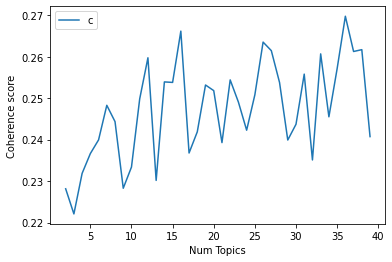

In [ ]:
# Show graph
limit = 40 
start = 2 
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()